In [1]:
import numpy as np
import json
import cvxpy as cp
from scipy import sparse as sp
import scipy.special as sps
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import math

from src.problems.utils import sample_data_for_group
from src.problems.problems import compute_producer_optimal_solution, _compute_consumer_optimal_solution_cvar_relaxed_base, _compute_consumer_optimal_solution_cvar
from src.problems.gradient_problem import compute_consumer_optimal_solution_cvar_grad

import matplotlib as mpl

In [2]:
sns.set_style("white")
mpl.rc('font', **{'size': 14})
plt.rcParams["font.family"] = "Times New Roman"
sns.set_palette("tab10")

In [79]:
# load data
with open("../../data/movielens_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("../../data/movielens_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

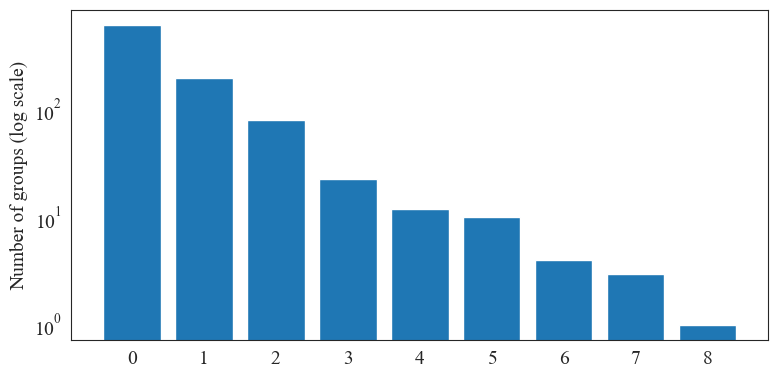

In [67]:
from collections import Counter

c = Counter()
for r in GROUPS_MAP:
    c[r["top_category"]] += 1


# plot distribution of groups sorted by size

fig, ax = plt.subplots(figsize=(8,4))
counts = sorted(c.values(), reverse=True)
ax.bar(range(len(counts)), counts, color="tab:blue")
ax.set_yscale('log')
ax.set_ylabel("Number of groups (log scale)")
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(range(len(counts)))   # or whatever your category labels are
plt.tight_layout()
plt.show()


<BarContainer object of 18 artists>

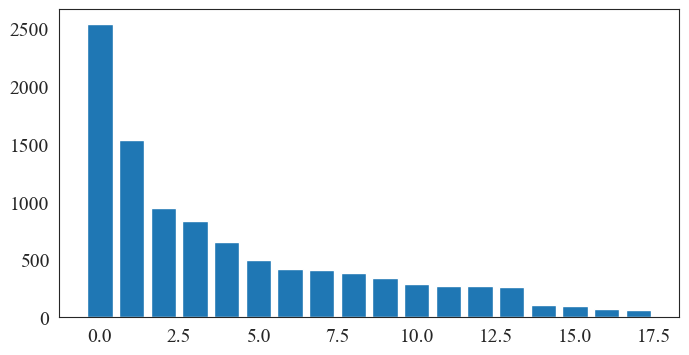

(array([2.1000000e+01, 2.4300000e+02, 1.1000000e+03, 2.7490000e+03,
        4.7090000e+03, 8.3890000e+03, 1.6404000e+04, 3.2280000e+04,
        5.9973000e+04, 1.0645100e+05, 1.8162100e+05, 2.9494800e+05,
        4.6421700e+05, 7.1453500e+05, 1.0804670e+06, 1.6097590e+06,
        2.3675370e+06, 3.4266460e+06, 4.8854110e+06, 6.8532610e+06,
        9.4469970e+06, 1.2819110e+07, 1.7032429e+07, 2.0974197e+07,
        1.4806546e+07]),
 array([0.150354  , 0.18433537, 0.21831674, 0.25229811, 0.28627947,
        0.32026084, 0.35424221, 0.38822358, 0.42220495, 0.45618632,
        0.49016768, 0.52414905, 0.55813042, 0.59211179, 0.62609316,
        0.66007452, 0.69405589, 0.72803726, 0.76201863, 0.796     ,
        0.82998136, 0.86396273, 0.8979441 , 0.93192547, 0.96590684,
        0.9998882 ]),
 <BarContainer object of 25 artists>)

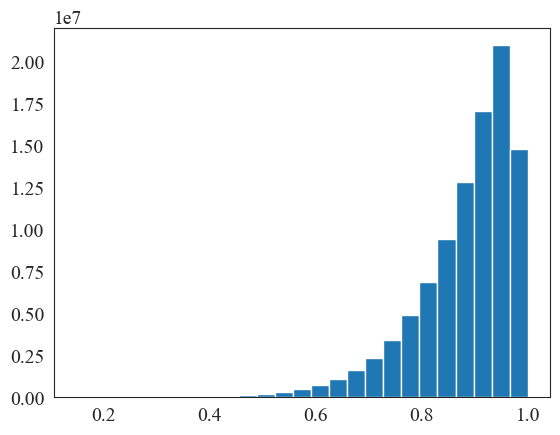

In [4]:
plt.hist(REL_MATRIX.flatten(), bins=25)

In [ ]:
def parse_groups_ids(groups_map: list[dict[str, int]], group_key: str):
    """Parses given group key value to int for each consumer"""

    # convert group key to int from 0 to n-1
    # where n is the number of groups
    group_ids = set()
    for group in groups_map:
        group_ids.add(group[group_key])

    group_ids = sorted(list(group_ids))
    group_ids_map = {group_id: i for i, group_id in enumerate(group_ids)}


    group_assignment = np.zeros(len(groups_map), dtype=int)
    for i, group in enumerate(groups_map):
        group_assignment[i] = group_ids_map[group[group_key]]
    return group_assignment



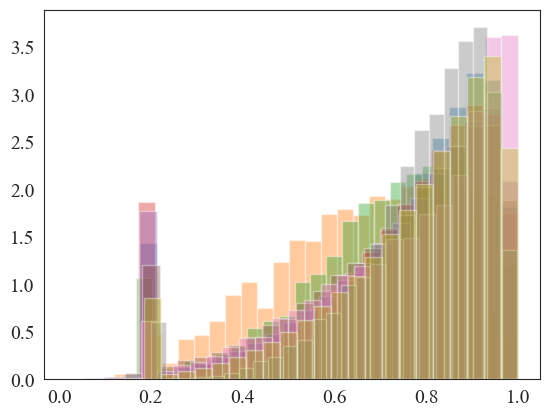

In [97]:
# load data
with open("../../data/movielens_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("../../data/movielens_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)


group_assignment = parse_groups_ids(GROUPS_MAP, "top_category")
for group in range(group_assignment.max() + 1):
    group_ids = np.where(group_assignment == group)[0]

    M = REL_MATRIX[group_ids]

    plt.hist(M.flatten(), bins=25, alpha=0.4, label=f"Group {group}", density=True)

In [ ]:
def get_group_shares(groups_map: list[dict[str, int]]) -> dict[str, int]:
    """Returns the size of each group in the groups map"""
    c = Counter()
    for group in groups_map:
        c[group["top_category"]] += 1

    # compute share
    total = sum(c.values())
    unique_groups = sorted(list(c.keys()))
    shares = []
    for group in unique_groups:
        shares.append(c[group] / total)

    return shares


In [101]:
get_group_shares(GROUPS_MAP)

[0.8898, 0.083, 0.0172, 0.0066, 0.0034]

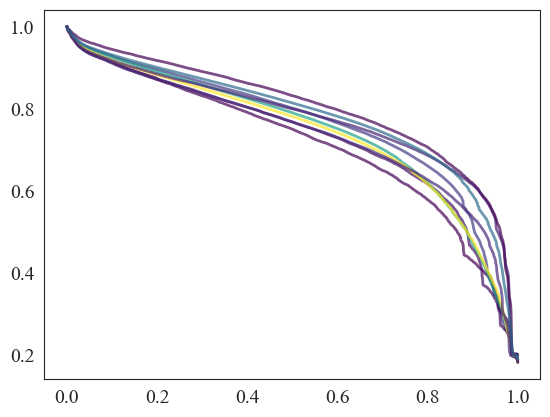

In [112]:
# load data
with open("../../data/movielens_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("../../data/movielens_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)


group_shares = get_group_shares(GROUPS_MAP)

norm = mpl.colors.PowerNorm(gamma=0.5,  # gamma<1 will exaggerate low values
                            vmin=min(group_shares),
                            vmax=max(group_shares))
cmap = plt.get_cmap("viridis")
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)



group_assignment = parse_groups_ids(GROUPS_MAP, "top_category")
colormap = plt.get_cmap("viridis")
for group in range(group_assignment.max() + 1):
    group_share = group_shares[group]
    share = group_shares[group]
    color = sm.to_rgba(share)
    group_ids = np.where(group_assignment == group)[0]

    M = REL_MATRIX[group_ids]

    order = np.argsort(M, axis=1)
    M = M[np.arange(M.shape[0])[:,None], order]
    M = M / M.max(axis=1, keepdims=True)
    M = M[:, ::-1]
    x = np.arange(M.shape[1]) / M.shape[1]
    plt.plot(x, M.mean(axis=0), color=color, alpha=0.7, linewidth=2)

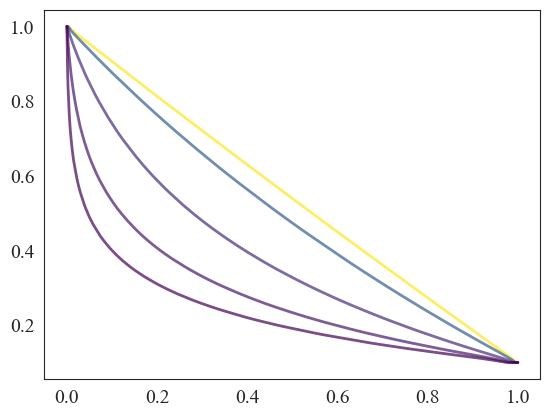

In [113]:
# load data
with open("../../data/simrec_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("../../data/simrec_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)


group_shares = get_group_shares(GROUPS_MAP)

norm = mpl.colors.PowerNorm(gamma=0.5,  # gamma<1 will exaggerate low values
                            vmin=min(group_shares),
                            vmax=max(group_shares))
cmap = plt.get_cmap("viridis")
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)



group_assignment = parse_groups_ids(GROUPS_MAP, "top_category")
colormap = plt.get_cmap("viridis")
for group in range(group_assignment.max() + 1):
    group_share = group_shares[group]
    share = group_shares[group]
    color = sm.to_rgba(share)
    group_ids = np.where(group_assignment == group)[0]

    M = REL_MATRIX[group_ids]

    order = np.argsort(M, axis=1)
    M = M[np.arange(M.shape[0])[:,None], order]
    M = M / M.max(axis=1, keepdims=True)
    M = M[:, ::-1]
    x = np.arange(M.shape[1]) / M.shape[1]
    plt.plot(x, M.mean(axis=0), color=color, alpha=0.7, linewidth=2)

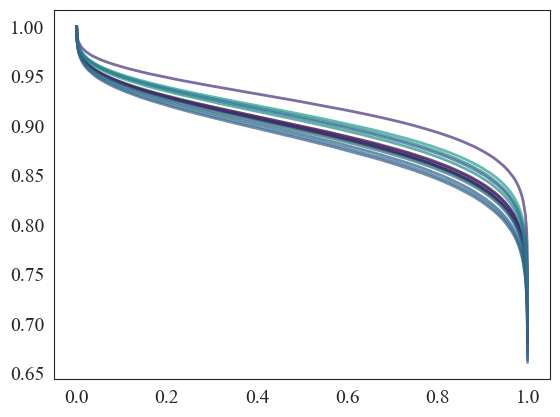

In [114]:
# load data
with open("../../data/amazon_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open("../../data/amazon_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

group_shares = get_group_shares(GROUPS_MAP)

norm = mpl.colors.PowerNorm(gamma=0.5,  # gamma<1 will exaggerate low values
                            vmin=min(group_shares),
                            vmax=max(group_shares))
cmap = plt.get_cmap("viridis")
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)



group_assignment = parse_groups_ids(GROUPS_MAP, "top_category")
colormap = plt.get_cmap("viridis")
for group in range(group_assignment.max() + 1):
    group_share = group_shares[group]
    share = group_shares[group]
    color = sm.to_rgba(share)
    group_ids = np.where(group_assignment == group)[0]

    M = REL_MATRIX[group_ids]

    order = np.argsort(M, axis=1)
    M = M[np.arange(M.shape[0])[:,None], order]
    M = M / M.max(axis=1, keepdims=True)
    M = M[:, ::-1]
    x = np.arange(M.shape[1]) / M.shape[1]
    plt.plot(x, M.mean(axis=0), color=color, alpha=0.7, linewidth=2)

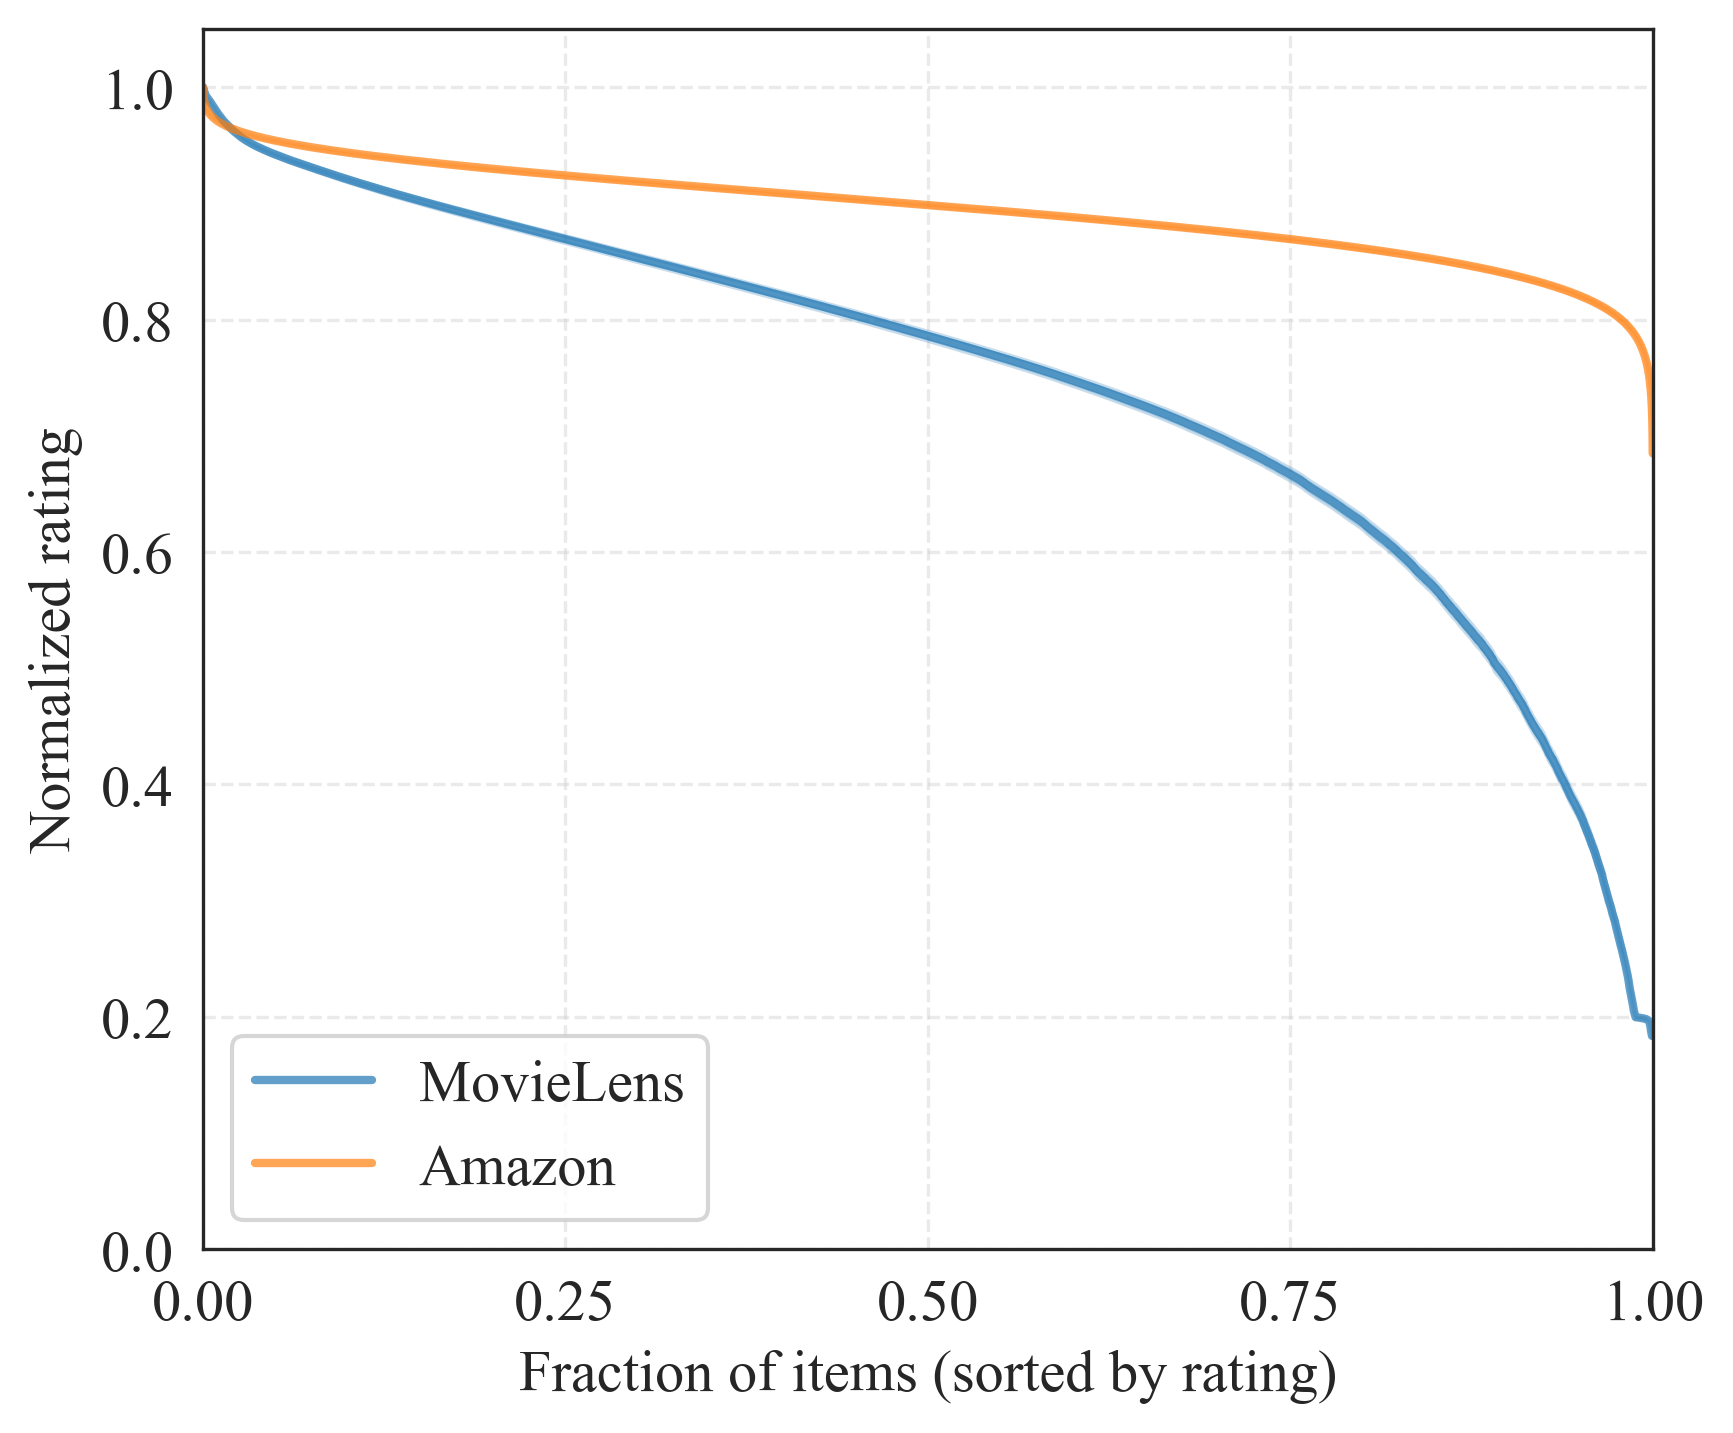

In [44]:
import numpy as np
import matplotlib.pyplot as plt

#plt.style.use("seaborn-talk")
colors = plt.get_cmap("tab10")
ml_color, am_color = colors(0), colors(1)

# -- load & process fn --
def load_profile(path):
    M = np.load(path)
    # sort per‐user, normalize, reverse
    order = np.argsort(M, axis=1)
    M = M[np.arange(M.shape[0])[:,None], order]
    M = M / M.max(axis=1, keepdims=True)
    M = M[:, ::-1]
    x = np.arange(M.shape[1]) / M.shape[1]
    return x, M.mean(axis=0), M.std(axis=0) / np.sqrt(M.shape[0])

x_ml, ml_mean, ml_sem = load_profile("../../data/movielens_predictions.npy")
x_am, am_mean, am_sem = load_profile("../../data/amazon_predictions.npy")

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
ax.plot(x_ml, ml_mean,    color=ml_color, linewidth=2, label="MovieLens", alpha=0.7)
ax.fill_between(x_ml, ml_mean - ml_sem, ml_mean + ml_sem,
                color=ml_color, alpha=0.25)
ax.plot(x_am, am_mean,    color=am_color, linewidth=2, label="Amazon", alpha=0.7)
ax.fill_between(x_am, am_mean - am_sem, am_mean + am_sem,
                color=am_color, alpha=0.25)

ax.grid(True, linestyle="--", alpha=0.4)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_ylim(0, 1.05)

#ax.set_title("Normalized Ratings vs. Fraction of Items", pad=15)
ax.set_xlabel("Fraction of items (sorted by rating)")
ax.set_ylabel("Normalized rating")
ax.legend(loc="lower left")

plt.tight_layout()
plt.savefig("normalized_ratings.pdf", bbox_inches="tight")

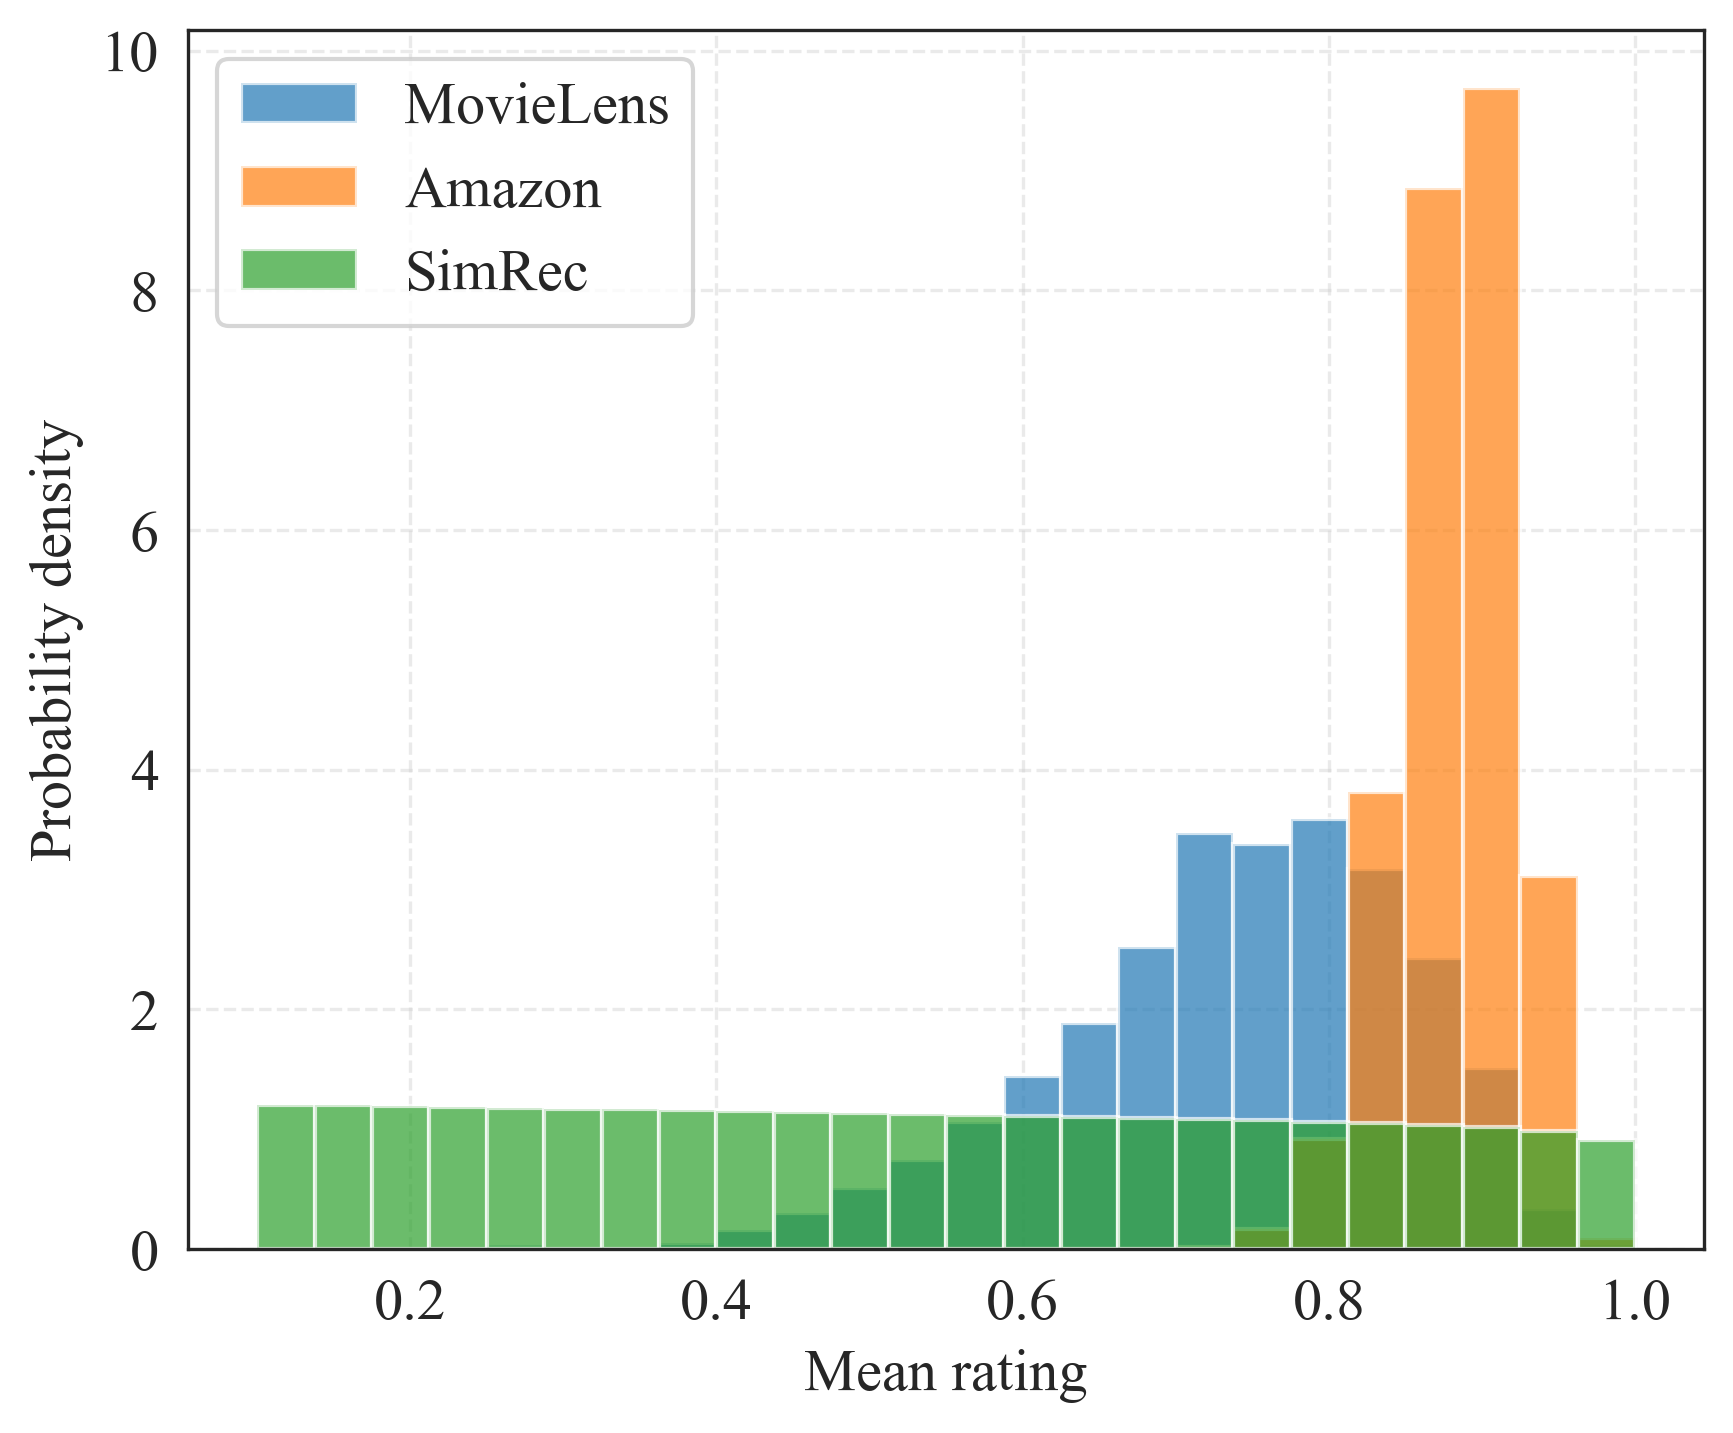

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# load MovieLens
with open("../../data/movielens_predictions.npy", "rb") as f:
    mov = np.load(f)
ml_means = mov.mean(axis=0)

# load Amazon
with open("../../data/amazon_predictions.npy", "rb") as f:
    amz = np.load(f)
am_means = amz.mean(axis=0)

with open("../../data/simrec_predictions.npy", "rb") as f:
    simrec = np.load(f)
simrec_means = simrec.mean(axis=0)

# define a common set of bins
bins = np.linspace(min(ml_means.min(), am_means.min(), simrec_means.min()),
                   max(ml_means.max(), am_means.max(), simrec_means.max()),
                   25)

fig = plt.figure(figsize=(6,5), dpi=300)
plt.grid(True, linestyle="--", alpha=0.4)
plt.hist(ml_means, bins=bins, density=True, alpha=0.7, label="MovieLens")
plt.hist(am_means, bins=bins, density=True, alpha=0.7, label="Amazon")
plt.hist(simrec_means, bins=bins, density=True, alpha=0.7, label="SimRec")
plt.xlabel("Mean rating")
plt.ylabel("Probability density")
plt.legend()
plt.tight_layout()
plt.savefig("ml_am_hist.pdf", bbox_inches="tight")
